### Block-Move Example 

$\quad$ Taken from ["An Introduction to Trajectory Optimization: How to Do Your Own Direct Collocation" by Matthew Kelly](https://epubs.siam.org/doi/epdf/10.1137/16M1062569).

$\quad$ 1.1. Notation. For reference, the main symbols we will use throughout the tutorial and which are described in detail later are as follows:  

$$
% \begin{equation}
\begin{array}{cc}
\begin{aligned}
& t_k && time~at~knot~point~k \\
& N && number~of~trajectory~(spline)~segments \\
& h_k = t_{k+1} − t_k && duration~of~spline~segment~k \\
& x_k = x(t_k) && state~at~knot~point~k \\
& u_k = u(t_k) && control~at~knot~point~k \\
& w_k = w(t_k, x_k, u_k) && integrand~of~objective~function~at~knot~point~k \\
& f_k = f(t_k, x_k, u_k) && system~dynamics~at~knot~point~k \\
& \dot{q} = \frac{\mathrm{d}}{\mathrm{d}t}q,~~~~\ddot{q} = \frac{\mathrm{d^2}}{\mathrm{d}t^2} && first~and~second~time-derivatives~of~q
\end{aligned}
\end{array}
% \end{equation}
$$
$\quad$ In some cases we will use the subscript $k + \frac{1}{2}$ to indicate the midpoint of spline segment k. For example, u_k gives the control at the beginning of segment k, and $u_{k+\frac{1}{2}}$ gives the control at the midpoint of segment k.


$\quad$ We would like the block to move one unit of distance in one unit of time, and it should
be stationary at both start and finish.  

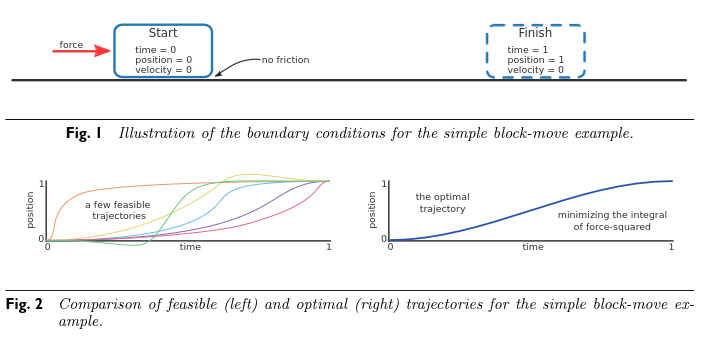

In [1]:
import osqp
import numpy as np
from scipy import sparse

N = 100
dt = 1 / N
deviation_weight = 0.0
speed_weight = 0.0
accel_weight = dt / 2

# Define problem data

# hessian
x_start_index = 0
v_start_index = x_start_index + N
u_start_index = v_start_index + N
matrix_size = 3 * N - 1
hessian = np.zeros((matrix_size, matrix_size))
for i in range(N):
    hessian[x_start_index + i, x_start_index + i] = deviation_weight * 2
    hessian[v_start_index + i, v_start_index + i] = speed_weight * 2
    if (i != N - 1):
        hessian[u_start_index + i, u_start_index + i] = accel_weight * 2 * 2

hessian[u_start_index, u_start_index] -= accel_weight
hessian[u_start_index + N - 2, u_start_index + N - 2] -= accel_weight
P = sparse.csc_matrix(hessian)

# constraints
x_start_index = 0
v_start_index = x_start_index + N
u_start_index = v_start_index + N
cons_x_update_start_index = 0
cons_v_update_start_index = cons_x_update_start_index + N - 1
cons_x_start_index = cons_v_update_start_index + N - 1
cons_x_end_index = cons_x_start_index + 1
cons_v_start_index = cons_x_end_index + 1
cons_v_end_index = cons_v_start_index + 1
cons = np.zeros((2 * (N - 1) + 4, 3 * N - 1))
for i in range(N - 1):
    cons[cons_x_update_start_index + i, x_start_index + i + 1] = cons[cons_v_update_start_index + i, v_start_index + i + 1] = 1
    cons[cons_x_update_start_index + i, x_start_index + i] = cons[cons_v_update_start_index +i, v_start_index + i] = -1
    cons[cons_x_update_start_index + i, v_start_index + i + 1] = -dt / 2
    cons[cons_x_update_start_index + i, v_start_index + i] = -dt / 2

    if (i != N - 2):
        cons[cons_v_update_start_index + i, u_start_index + i + 1] = -dt / 2
    cons[cons_v_update_start_index + i, u_start_index + i] = -dt / 2

cons[cons_x_start_index, x_start_index] = cons[cons_v_start_index, v_start_index] = cons[cons_v_end_index, v_start_index + N - 1] = cons[cons_x_end_index, x_start_index + N - 1] = 1

# bounds
lower_bound = np.zeros((2 * (N - 1) + 4, 1))
upper_bound = np.zeros((2 * (N - 1) + 4, 1))
for i in range(N - 1):
    lower_bound[cons_x_update_start_index + i] = upper_bound[cons_x_update_start_index + i] = 0
    lower_bound[cons_v_update_start_index + i] = upper_bound[cons_v_update_start_index + i] = 0

lower_bound[cons_x_start_index] = upper_bound[cons_x_start_index] = 0
lower_bound[cons_x_end_index] = upper_bound[cons_x_end_index] = 1
lower_bound[cons_v_start_index] = upper_bound[cons_v_start_index] = 0
lower_bound[cons_v_end_index] = upper_bound[cons_v_end_index] = 0

A = sparse.csc_matrix(cons)
l = lower_bound
u = upper_bound

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P=P, A=A, l=l, u=u)

# Solve problem
res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 299, constraints m = 202
          nnz(P) + nnz(A) = 894
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.00e+02   1.00e-01   5.21e-04s
  50   1.1134e+01   5.13e-04   2.88e-09   1.00e-01   1.38e-03s

status:               solved
number of itera

In [2]:
# analytic solution
def f(t):
    return 3 * t * t - 2 * t * t * t

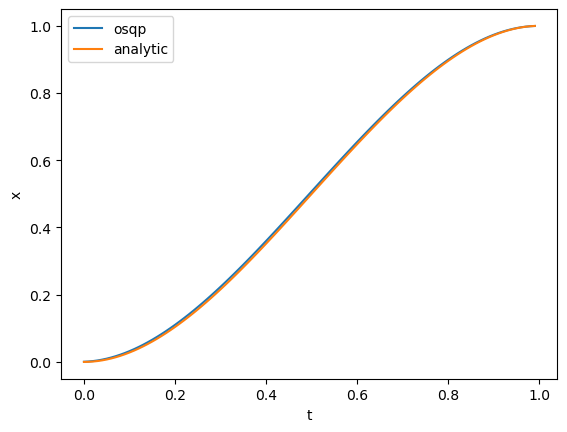

In [3]:
import matplotlib.pyplot as plt

t = np.arange(0, 1, dt)
x = res.x[:N]
anal_x = [f(i) for i in t]
plt.plot(t, x, label="osqp")
plt.plot(t, anal_x, label="analytic")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('x')
plt.show()